# QWOP Project 5

This project involves a few codes, in the following, the physics engine is not required for you to understand, you just need to know, this engine works whenever you feed a 40 floating point array (list) to this function. 

For you ease of use, I provided a data-collection free version of the following code, which is called ``QWOP`` in the next block.

In [9]:
# This code is based on an assignment designed by Paul Valiant.  
# Please do not disseminate this code without his written permission.
#
# This python implementation was written by Okke Schrijvers

import sys
import math
import numpy as np
import time
from matplotlib import pyplot as plt
from matplotlib import animation
import copy
import random
import time

# plan is an array of 40 floating point numbers

def sim(plan):
    data = []
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1
    friction = 1.0
    gravity = 0.1
    mass = [30, 10, 5, 10, 5, 10]
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9]
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]
    anglessp = [20.0, 20.0, 10.0, 10.0]
    anglesf = [8.0, 8.0, 4.0, 4.0]
    
    edge = [(0, 1),(1, 2),(0, 3),(3, 4),(0, 5)]
    angles = [(4, 0),(4, 2),(0, 1),(2, 3)]
    
    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0,0.0,0.0,0.0,0.0,0.0], [0.0,0.0,0.0,0.0,0.0,0.0]]
    p = [[0, 0, -.25, .25, .25, .15], [1, .5, 0, .5, 0, 1.9]]
    
    spin = 0.0
    maxspin = 0.0
    lastang = 0.0
    
    for j in range(20):
        for k in range(10):
            lamb = 0.05 + 0.1*k
            t0 = 0.5
            if j>0:
                t0 = plan[2*j-2]
            t0 *= (1-lamb)
            t0 += plan[2*j]*lamb
            
            t1 = 0.0
            if j>0:
                t1 = plan[2*j-1]
            t1 *= (1-lamb)
            t1 += plan[2*j+1]*lamb
            
            

            contact = [False,False,False,False,False,False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8+t0), -(2.8-t0), -(1-t1)*.9, -(1+t1)*.9]

            disp = [[0,0,0,0,0],[0,0,0,0,0]]
            dist = [0,0,0,0,0]
            dispn = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]]-p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]]-p[1][edge[z][0]]
                dist[z] = math.sqrt(disp[0][z]*disp[0][z] + disp[1][z]*disp[1][z])
                inv = 1.0/dist[z];
                dispn[0][z] = disp[0][z]*inv
                dispn[1][z] = disp[1][z]*inv;
        
            dispv = [[0,0,0,0,0],[0,0,0,0,0]]
            distv = [0,0,0,0,0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2*(disp[0][z]*dispv[0][z] + disp[1][z]*dispv[1][z])

            
            forceedge = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                c = (edgel[z]-dist[z])*edgesp[z]-distv[z]*edgef[z]
                forceedge[0][z] = c*dispn[0][z]
                forceedge[1][z] = c*dispn[1][z]

            edgeang = [0,0,0,0,0]
            edgeangv = [0,0,0,0,0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z]*disp[1][z]-dispv[1][z]*disp[0][z])/(dist[z]*dist[z])

            inc = edgeang[4] - lastang
            if (inc < -math.pi):
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - .005*(k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0,0,0,0]
            for z in range(4):
                angv[z] = edgeangv[angles[z][1]]-edgeangv[angles[z][0]];

            angf = [0,0,0,0]
            for z in range(4):
                ang = edgeang[angles[z][1]]-edgeang[angles[z][0]]-anglesl[z]
                if ang > math.pi:
                    ang -= 2*math.pi
                elif ang < -math.pi:
                    ang += 2*math.pi
                m0 = dist[angles[z][0]]/edgel[angles[z][0]]
                m1 = dist[angles[z][1]]/edgel[angles[z][1]]
                angf[z] = ang*anglessp[z]-angv[z]*anglesf[z]*min(m0,m1)

            edgetorque = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                inv = 1.0 / (dist[z]*dist[z])
                edgetorque[0][z] = -disp[1][z]*inv
                edgetorque[1][z] =  disp[0][z]*inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z]*edgetorque[0][i0]
                forceedge[1][i0] += angf[z]*edgetorque[1][i0]
                forceedge[0][i1] -= angf[z]*edgetorque[0][i1]
                forceedge[1][i1] -= angf[z]*edgetorque[1][i1]

            f = [[0,0,0,0,0,0],[0,0,0,0,0,0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity*mass[z]
                invm = 1.0/mass[z]
                v[0][z] += f[0][z]*dt*invm
                v[1][z] += f[1][z]*dt*invm
                
                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z]*s < fric*friction:
                        v[0][z]=0
                    else:
                        v[0][z] -= fric*friction*s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt;

            data.append(copy.deepcopy(p))


            if contact[0] or contact[5]:
                return p[0][5], data 
    return p[0][5], data



def visualize(plan):
    distance, data = sim(plan)
    print('total distance traveled {dis}'.format(dis=distance))

    # draw the simulation
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)

    ax = plt.axes(xlim=(-1, 10), ylim=(0, 3))

    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0,0],[0,0]],closed=None, fill=None, edgecolor='k')
    head = plt.Circle((0, 0), radius=0.15, fc='k', ec='k')

    def init():
        ax.add_patch(patch)
        ax.add_patch(head)
        return patch,head


    def animate(j):
        points = np.array([[data[j][0][i] for i in joints], [data[j][1][i] for i in joints]]).T
        patch.set_xy(points)
        head.center = (data[j][0][5], data[j][1][5])
        return patch,head

    anim = animation.FuncAnimation(fig, animate,
                                   init_func=init,
                                   frames=len(data),
                                   interval=20, blit=True)
    anim.save('animation.mp4', fps=50,extra_args=['-vcodec', 'libx264'])

    plt.show()

##  The data-collection-free version of the previous code

This is the function I am trying to maximize.

In [4]:
# In this code, the data collection is removed for speed consideration. 
# So this function is suitable for your optimization. 

def QWOP(plan):
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1
    friction = 1.0
    gravity = 0.1
    mass = [30, 10, 5, 10, 5, 10]
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9]
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]
    anglessp = [20.0, 20.0, 10.0, 10.0]
    anglesf = [8.0, 8.0, 4.0, 4.0]
    
    edge = [(0, 1),(1, 2),(0, 3),(3, 4),(0, 5)]
    angles = [(4, 0),(4, 2),(0, 1),(2, 3)]
    
    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0,0.0,0.0,0.0,0.0,0.0], [0.0,0.0,0.0,0.0,0.0,0.0]]
    p = [[0, 0, -.25, .25, .25, .15], [1, .5, 0, .5, 0, 1.9]]
    
    spin = 0.0
    maxspin = 0.0
    lastang = 0.0
    
    for j in range(20):
        for k in range(10):
            lamb = 0.05 + 0.1*k
            t0 = 0.5
            if j>0:
                t0 = plan[2*j-2]
            t0 *= (1-lamb)
            t0 += plan[2*j]*lamb
            
            t1 = 0.0
            if j>0:
                t1 = plan[2*j-1]
            t1 *= (1-lamb)
            t1 += plan[2*j+1]*lamb
            
            

            contact = [False,False,False,False,False,False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8+t0), -(2.8-t0), -(1-t1)*.9, -(1+t1)*.9]

            disp = [[0,0,0,0,0],[0,0,0,0,0]]
            dist = [0,0,0,0,0]
            dispn = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]]-p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]]-p[1][edge[z][0]]
                dist[z] = math.sqrt(disp[0][z]*disp[0][z] + disp[1][z]*disp[1][z])
                inv = 1.0/dist[z];
                dispn[0][z] = disp[0][z]*inv
                dispn[1][z] = disp[1][z]*inv;
        
            dispv = [[0,0,0,0,0],[0,0,0,0,0]]
            distv = [0,0,0,0,0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2*(disp[0][z]*dispv[0][z] + disp[1][z]*dispv[1][z])

            
            forceedge = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                c = (edgel[z]-dist[z])*edgesp[z]-distv[z]*edgef[z]
                forceedge[0][z] = c*dispn[0][z]
                forceedge[1][z] = c*dispn[1][z]

            edgeang = [0,0,0,0,0]
            edgeangv = [0,0,0,0,0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z]*disp[1][z]-dispv[1][z]*disp[0][z])/(dist[z]*dist[z])

            inc = edgeang[4] - lastang
            if (inc < -math.pi):
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - .005*(k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0,0,0,0]
            for z in range(4):
                angv[z] = edgeangv[angles[z][1]]-edgeangv[angles[z][0]];

            angf = [0,0,0,0]
            for z in range(4):
                ang = edgeang[angles[z][1]]-edgeang[angles[z][0]]-anglesl[z]
                if ang > math.pi:
                    ang -= 2*math.pi
                elif ang < -math.pi:
                    ang += 2*math.pi
                m0 = dist[angles[z][0]]/edgel[angles[z][0]]
                m1 = dist[angles[z][1]]/edgel[angles[z][1]]
                angf[z] = ang*anglessp[z]-angv[z]*anglesf[z]*min(m0,m1)

            edgetorque = [[0,0,0,0,0],[0,0,0,0,0]]
            for z in range(5):
                inv = 1.0 / (dist[z]*dist[z])
                edgetorque[0][z] = -disp[1][z]*inv
                edgetorque[1][z] =  disp[0][z]*inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z]*edgetorque[0][i0]
                forceedge[1][i0] += angf[z]*edgetorque[1][i0]
                forceedge[0][i1] -= angf[z]*edgetorque[0][i1]
                forceedge[1][i1] -= angf[z]*edgetorque[1][i1]

            f = [[0,0,0,0,0,0],[0,0,0,0,0,0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity*mass[z]
                invm = 1.0/mass[z]
                v[0][z] += f[0][z]*dt*invm
                v[1][z] += f[1][z]*dt*invm
                
                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z]*s < fric*friction:
                        v[0][z]=0
                    else:
                        v[0][z] -= fric*friction*s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt;

            if contact[0] or contact[5]:
                return p[0][5]
    return -p[0][5]

# Differential revolution algorithm

Here is the main body of the differential revolution algorithm mainly for QWOP function. There are 40 parameters with the first 20 control the angle of the runner's thighs and the last 20 control the runner's knees. The bound for each parameter is uniformly (-1, 1). For a generalized version of the de function, the number of parameters and the bounds for all parameters might differ so we need to modify the function slightly to adjust this change.

In [ ]:
# All maximization problem can be converted into max f = min -f.
f = lambda x: -QWOP(x) 

In [14]:
# Differential Revolution function
import numpy as np

def de(objFunc, popSize=20, cP=.7, mu=.8, maxIter=1000): 
    '''Deploy differential revolution algorithm to minimize QWOP function
    popSize -- Number of solutions in the population
    cP -- Crossover probability, float in [0, 1]
    mu -- mutantWeight, float in [0, 2]
    maxIter -- max number of iterations'''
    dim = 40
    bound = (-1, 1)
    pop = np.random.uniform(low=bound[0], high=bound[1], size = (popSize, dim)) # Initialization 
    for ite in range(maxIter):
        for i in range(popSize):
            Xi = pop[i]
            idx_not_include_i = [idx for idx in range(popSize) if idx != i]           # collecting indexes different from i
            Xa, Xb, Xc = pop[np.random.choice(idx_not_include_i, size=3, replace=False)]  # randomly selecting 3 sets of sol's
            unif_rand_num = np.random.random(dim)
            R_idx = np.random.choice(dim)
            yi = np.zeros(dim)
            for j in range(dim):
                if (unif_rand_num[j] < cP) or (j == R_idx):
                    yi[j] = np.clip(Xa[j] + mu * (Xb[j] - Xc[j]), -1, 1)
                else:
                    yi[j] = Xi[j]
            if objFunc(yi) < objFunc(Xi):
                pop[i] = yi
                
    pop_sol = np.asarray([objFunc(x) for x in pop])  
    min_idx = np.argmin(pop_sol)
    min_value = pop_sol[min_idx]
    
    return (min_value, pop[min_idx])

Here is my strategy:
       1. Since I didn't know the optimal set of hyperparameters for this optimization problem in the first place, I tested the performance of different population sizes with different random seeds by comparing the min values in 300 iterations. At the end, I chose the popSize to be 40 (Since for different popSize, the solution sets differed, the comparison weren't really fair. But after 5 times of experiment, popSize = 40 seems to be optimal, among 20, 30, 40, 50 and 60).
       
       2. Having chosen popSize=40, I ran the de for multiple times to select the most potential solution set, i.e. the set of 40 solutions with which de generates the smallest value.
       
       3. I ran the de with a specified set of hyperparameters, like cP = 0.7, mu = 0.75, maxIter = 350...etc, saved the solution set and used the same solution in de with different set of hyperparamers.
       
       4. Many many step 3.

Here is just an example of what I did in step 1 (I ended up chooing popSize = 4 with the set of solutions that yields a min avlue of 8.6 in 300 iterations.

In [15]:
for popSize in [30, 40, 50]:
    ans = de(f, popSize=popSize, maxIter=300)
    print('For a popSize of', popSize, 'The min value is:', ans[0])
    print('The solution is:', ans[1])

For a popSize of 30 The min value is: -7.028315106489663
The solution is: [ 0.45299002  1.          0.93541584  0.63894812  0.88946153  0.94895166
  0.53678357  1.         -1.         -0.69801198 -1.         -0.77054035
 -0.32866681  0.38472388  0.44541378 -0.75192813 -0.18226923  1.
 -1.         -1.         -0.95809225 -1.          0.73363911 -0.43032117
 -0.20048645  1.         -0.03015436  0.5728401  -1.         -1.
 -0.71894081 -0.63827734  0.22857862 -1.          0.11160359  1.
 -0.19549881  1.         -1.         -0.29498748]
For a popSize of 40 The min value is: -8.479157823303096
The solution is: [ 0.69314595  1.          0.95031868  0.66784424  1.          1.
  1.          1.         -1.         -0.79525348  0.21074395 -1.
 -0.52887881  0.13012609 -0.0185465   1.         -0.77852168 -1.
 -1.         -1.         -0.55753445 -1.          1.          1.
  0.58434933  0.71043085 -0.53626979 -0.72338068  1.         -0.66669692
  0.95570575  1.          1.          1.         -1.   

# Experiment Part

Many many step 3 and many many more step 4..

Best solution generated by:
1. popSize = 40
2. crossProb = varied
3. mutantWeight = varied
4. iteration = 300 each time

In [10]:
objFunc = f
popSize=40
#crossProb=.8
#mutantWeight=.85
maxIter=300
dim = 40

import time
start = time.time()

for cP in [0.00001]:
    for mut in [0.6]:
        for ite in range(maxIter):
            for i in range(popSize):
                Xi = pop[i]
                idx_not_include_i = [idx for idx in range(popSize) if idx != i]     
                Xa, Xb, Xc = pop[np.random.choice(idx_not_include_i, size=3, replace=False)]
                unif_rand_num = np.random.random(dim)
                R_idx = np.random.choice(dim)
                yi = np.zeros(dim)
                for j in range(dim):
                    if (unif_rand_num[j] < cP) or (j == R_idx):
                        yi[j] = np.clip(Xa[j] + mut * (Xb[j] - Xc[j]), -1, 1)
                    else:
                        yi[j] = Xi[j]
                if objFunc(yi) < objFunc(Xi):
                    pop[i] = yi
        pop_sol = np.asarray([objFunc(x) for x in pop])  
        min_idx = np.argmin(pop_sol)
        minimum = pop_sol[min_idx]
        print('mu:', mut)
        print('The min value is:', minimum)
        print('The solution is:', pop[min_idx])
        print()
        
end = time.time()
print('The total run time is:', end-start, 's.')

mu: 0.6
The min value is: -10.601951872468277
The solution is: [ 0.70262125  0.91333552  0.99028002  0.99903275  0.9992121   1.
  0.40834442  0.99810148 -0.53662944 -0.98789511 -0.41972958 -0.97628785
 -0.99410522 -0.37748291 -0.20261961 -0.91754104  0.92104716  0.96920712
  0.98287526  1.          0.03126903  1.         -0.85080811 -0.9999888
  0.51827596  0.03351509 -0.99997829 -0.96630054  0.95489143  0.97795999
 -1.         -0.84779874  0.95046789  0.8558515  -0.99985987 -0.80730514
  0.44500793  0.82628708 -0.82156415  0.99999813]

The total run time is: 828.2113177776337 s.


# The best solution so far...

In [35]:
#The min value is: -10.601951889064436
sol = np.array([ 0.70262125,  0.91333552,  0.99028002,  0.99903275,  0.9992121 ,
        1.        ,  0.40834442,  0.99810148, -0.53662944, -0.98789511,
       -0.41972958, -0.97628785, -0.99410522, -0.37748291, -0.20261961,
       -0.91754104,  0.92104716,  0.96920712,  0.98287526,  1.        ,
        0.03126903,  1.        , -0.85080811, -0.9999888 ,  0.51827596,
        0.03351509, -0.99997829, -0.96630054,  0.95489143,  0.97795999,
       -1.        , -0.84779874,  0.95046789,  0.8558515 , -0.99985987,
       -0.80730514,  0.44500793,  0.82628708, -0.82156415,  0.99999813])

In [38]:
QWOP(sol)

10.601951889064436

total distance traveled 10.601951889064436


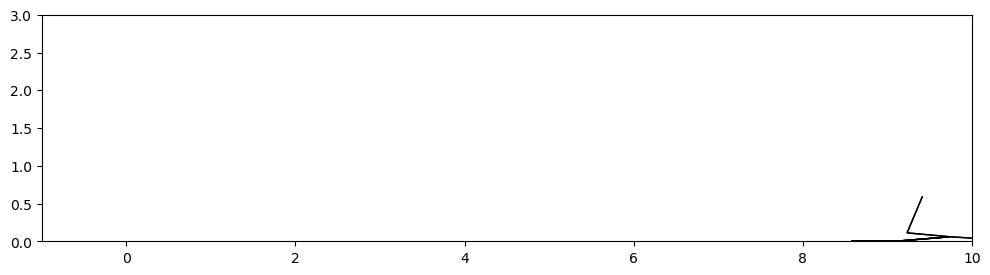

In [36]:
visualize(sol)

### Observe that any further iterations can only improve the distance by 0.000000001. Speculate that the value of 10.6 is either the local or global minimum under the current solution set. With different popSize, the min value might differ, and it's up to you to implement.

Btw, thank you Professor Zhong for creating this project, I really had fun. 